# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Link to contest : https://www.kaggle.com/c/titanic/overview/description

## 1) Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

## 2) Data Preprocessing

* **Data Dictionary**

- survival ---	Survival	0 = No, 1 = Yes
- pclass	 ---   Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	     ---   Sex	
- Age	     ---   Age in years	
- sibsp    ---  	# of siblings / spouses aboard the Titanic	
- parch    --- 	# of parents / children aboard the Titanic	
- ticket	 ---   Ticket number	
- fare	   ---   Passenger fare	
- cabin    --- 	Cabin number	
- embarked --- 	Port of Embarkation	C = Cherbourg, Q =  Queenstown, S = Southampton

- Variable Notes
* pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [51]:
# For train

df_train = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# For test 

df_test = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

# Extract the titles from the name and put them in a list, then correct them

# Train data

train_titles = list()
for name in df_train["Name"]:
    train_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(train_titles)):
    train_titles[i] = title_corr(train_titles[i])
df_train["Titles"] = train_titles

# Test set 

test_titles = list()
for name in df_test["Name"]:
    test_titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(test_titles)):
    test_titles[i] = title_corr(test_titles[i])
df_test["Titles"] = test_titles

In [0]:
# Train Data

df_train['Total Family'] = df_train['SibSp'] + df_train['Parch']

# Test Data

df_test['Total Family'] = df_test['SibSp'] + df_test['Parch']


In [205]:
# For train 
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Total Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,1.536476,1.994388,0.904602
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.791503,0.792501,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,2.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000,2.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,4.000000,10.000000


In [206]:
# For test 
df_test.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Total Family
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.636364,29.599282,0.447368,0.392344,35.576535,1.401914,2.066986,0.839713
std,120.810458,0.841838,0.481622,12.703770,0.896760,0.981429,55.850103,0.854496,0.780648,1.519072
min,892.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,1.000000,2.000000,0.000000
50%,1100.500000,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200,2.000000,2.000000,0.000000
75%,1204.750000,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875,2.000000,2.000000,1.000000
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000,4.000000,10.000000


In [56]:
len(df_train) , len(df_test)

(891, 418)

In [57]:
# For train

df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

In [58]:
# For test

df_test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

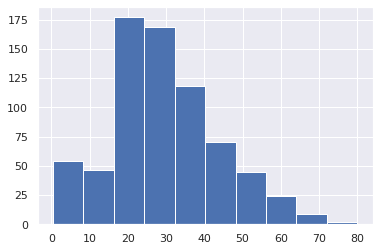

In [59]:
plt.hist(df_train['Age'])

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

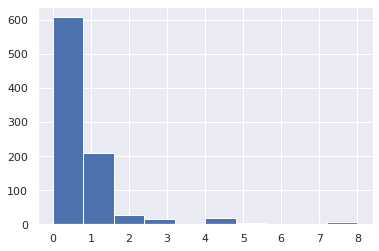

In [60]:
plt.hist(df_train['SibSp'])

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

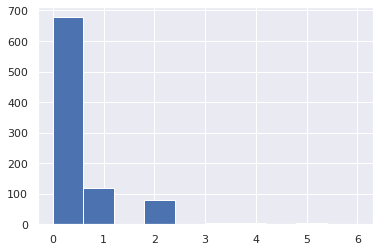

In [61]:
plt.hist(df_train['Parch'])

In [62]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


- Here, we can see that Cabin has got about 80-85% null values.So, it can be removed.
- Moreover, Name and Ticket are not good parameters for training.
- Therefore, these columns can be removed.

In [63]:
"""
# For train

df_train['Cabin'] = df_train['Cabin'].fillna('Unknow')
df_train['Cabin2'] = df_train['Cabin'].apply(lambda x : len(x))

# For test

df_test['Cabin'] = df_test['Cabin'].fillna('Unknow')
df_test['Cabin2'] = df_test['Cabin'].apply(lambda x : len(x))
"""

"\n# For train\n\ndf_train['Cabin'] = df_train['Cabin'].fillna('Unknow')\ndf_train['Cabin2'] = df_train['Cabin'].apply(lambda x : len(x))\n\n# For test\n\ndf_test['Cabin'] = df_test['Cabin'].fillna('Unknow')\ndf_test['Cabin2'] = df_test['Cabin'].apply(lambda x : len(x))\n"

In [0]:
#sns.barplot('Cabin2','Survived',data=df_train)

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


In [66]:
df_train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

In [67]:
df_test.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

In [0]:
# For train 

df_train = df_train.drop('Name',axis=1)
df_train = df_train.drop('Ticket',axis=1)
df_train = df_train.drop('Cabin',axis=1)
df_train['Age'].fillna(df_train['Age'].median(),inplace=True)
df_train['Embarked'].fillna('S',inplace=True)

# For test

df_test['Fare'].fillna(df_test['Fare'].median(),inplace=True)
df_test = df_test.drop('Name',axis=1)
df_test = df_test.drop('Ticket',axis=1)
df_test = df_test.drop('Cabin',axis=1)
df_test['Age'].fillna(df_test['Age'].median(),inplace=True)

In [69]:
# Converting the Object datatype into Category type

cat_cols = []
for col in df_train.columns:
  if df_train[col].dtype == 'O':
    cat_cols.append(col)

print(cat_cols)    

['Sex', 'Embarked', 'Titles']


In [0]:
# For Train

for col in cat_cols:
  df_train[col] = df_train[col].astype('category')

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].astype('category')


In [0]:
# Converting the category cols to integers

# For Train

for col in cat_cols:
  df_train[col] = df_train[col].cat.codes.values

# For Test

for col in cat_cols:
  df_test[col] = df_test[col].cat.codes.values  

In [72]:
# For train

train_cat_data = df_train[['Pclass','Sex','Embarked','Titles']].values
print(train_cat_data)

# For test
test_cat_data = df_test[['Pclass','Sex','Embarked','Titles']].values
print(test_cat_data)

[[3 1 2 2]
 [1 0 0 3]
 [3 0 2 1]
 ...
 [3 0 2 1]
 [1 1 0 2]
 [3 1 1 2]]
[[3 1 1 2]
 [3 0 2 3]
 [2 1 1 2]
 ...
 [3 1 2 2]
 [3 1 2 2]
 [3 1 0 4]]


In [73]:
# For train

print(max(df_train['Pclass']), max(df_train['Sex']), max(df_train['Embarked']),max(df_train['Titles']))
print(min(df_train['Pclass']), min(df_train['Sex']), min(df_train['Embarked']),min(df_train['Titles']))

3 1 2 4
1 0 0 0


In [74]:
# For test

print(max(df_test['Pclass']), max(df_test['Sex']), max(df_test['Embarked']),max(df_test['Titles']))
print(min(df_test['Pclass']), min(df_test['Sex']), min(df_test['Embarked']),min(df_test['Titles']))

3 1 2 4
1 0 0 0


In [75]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 

# For train

train_cat_data = onehotencoder.fit_transform(train_cat_data).toarray()
print(train_cat_data.shape, type(train_cat_data))
print(train_cat_data)

# For test

test_cat_data = onehotencoder.transform(test_cat_data).toarray()
print(test_cat_data.shape, type(test_cat_data))
print(test_cat_data)


(891, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]
(418, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [76]:
df_train.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
dtype: int64

In [77]:
df_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
dtype: int64

In [185]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Titles', 'Total Family'],
      dtype='object')

In [0]:
# Splitting the data into features and labels

# For train

X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Titles', 'Total Family']].values
y = df_train['Survived'].values

# For test

X_test = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Titles', 'Total Family']].values

In [187]:
X.shape, X[:10], type(X)

((891, 9),
 array([[ 3.    ,  1.    , 22.    ,  1.    ,  0.    ,  7.25  ,  2.    ,
          2.    ,  1.    ],
        [ 1.    ,  0.    , 38.    ,  1.    ,  0.    , 71.2833,  0.    ,
          3.    ,  1.    ],
        [ 3.    ,  0.    , 26.    ,  0.    ,  0.    ,  7.925 ,  2.    ,
          1.    ,  0.    ],
        [ 1.    ,  0.    , 35.    ,  1.    ,  0.    , 53.1   ,  2.    ,
          3.    ,  1.    ],
        [ 3.    ,  1.    , 35.    ,  0.    ,  0.    ,  8.05  ,  2.    ,
          2.    ,  0.    ],
        [ 3.    ,  1.    , 28.    ,  0.    ,  0.    ,  8.4583,  1.    ,
          2.    ,  0.    ],
        [ 1.    ,  1.    , 54.    ,  0.    ,  0.    , 51.8625,  2.    ,
          2.    ,  0.    ],
        [ 3.    ,  1.    ,  2.    ,  3.    ,  1.    , 21.075 ,  2.    ,
          4.    ,  4.    ],
        [ 3.    ,  0.    , 27.    ,  0.    ,  2.    , 11.1333,  2.    ,
          3.    ,  2.    ],
        [ 2.    ,  0.    , 14.    ,  1.    ,  0.    , 30.0708,  0.    ,
          3.    ,

In [80]:
"""
# For train

X = np.concatenate((X,train_cat_data),axis=1)
print(X)

# For test 

X_test = np.concatenate((X_test,test_cat_data),axis=1)
print(X_test)
"""

[[22.      7.25    1.     ...  1.      0.      0.    ]
 [38.     71.2833  1.     ...  0.      1.      0.    ]
 [26.      7.925   0.     ...  0.      0.      0.    ]
 ...
 [28.     23.45    3.     ...  0.      0.      0.    ]
 [26.     30.      0.     ...  1.      0.      0.    ]
 [32.      7.75    0.     ...  1.      0.      0.    ]]
[[34.5     7.8292  0.     ...  1.      0.      0.    ]
 [47.      7.      1.     ...  0.      1.      0.    ]
 [62.      9.6875  0.     ...  1.      0.      0.    ]
 ...
 [38.5     7.25    0.     ...  1.      0.      0.    ]
 [27.      8.05    0.     ...  1.      0.      0.    ]
 [27.     22.3583  2.     ...  0.      0.      1.    ]]


In [81]:
X.shape, type(X)

((891, 16), numpy.ndarray)

In [82]:
y.shape , y[:10]

((891,), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

In [83]:
X_test.shape, type(X_test)

((418, 16), numpy.ndarray)

In [84]:
input_data = xgb.DMatrix(data=X,label=y)
input_data

## 3) Splitting the data into train and test set

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [0]:
train_data = xgb.DMatrix(data=X_train,label=y_train)
test_data = xgb.DMatrix(data=X_val,label=y_val)

In [0]:
actual_testing_data = xgb.DMatrix(data=X_test)

## 4) Building the XGBoost Model

In [0]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree=0.4,
                           learning_rate = 0.1,
                          max_depth = 6,  
                          n_estimators = 26,
                          random_state = 10 )

In [89]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=26, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 6) Predicting the validation set results

In [0]:
y_preds = xg_clf.predict(X_val)

In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_val)
print(cm)

[[49  9]
 [ 2 30]]


In [92]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8777777777777778


## 7) Training and Tuning XgBoost Model

In [208]:
# hyper parameter tuning

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric':'auc',
    'early_stopping_rounds':10,
    # Other parameters
    'objective':'binary:logistic',
}

model = xgb.train(
    params,
    train_data,
    num_boost_round=100,
    evals=[(test_data, "Test")]
)

[0]	Test-auc:0.88537
[1]	Test-auc:0.86903
[2]	Test-auc:0.864505
[3]	Test-auc:0.870287
[4]	Test-auc:0.866013
[5]	Test-auc:0.857969
[6]	Test-auc:0.870789
[7]	Test-auc:0.873806
[8]	Test-auc:0.872046
[9]	Test-auc:0.862996
[10]	Test-auc:0.858472
[11]	Test-auc:0.858974
[12]	Test-auc:0.85822
[13]	Test-auc:0.855455
[14]	Test-auc:0.855706
[15]	Test-auc:0.851182
[16]	Test-auc:0.855204
[17]	Test-auc:0.854198
[18]	Test-auc:0.85269
[19]	Test-auc:0.851684
[20]	Test-auc:0.854701
[21]	Test-auc:0.851684
[22]	Test-auc:0.853193
[23]	Test-auc:0.853695
[24]	Test-auc:0.854198
[25]	Test-auc:0.85269
[26]	Test-auc:0.853695
[27]	Test-auc:0.857215
[28]	Test-auc:0.851684
[29]	Test-auc:0.850679
[30]	Test-auc:0.853695
[31]	Test-auc:0.854701
[32]	Test-auc:0.854198
[33]	Test-auc:0.854701
[34]	Test-auc:0.85822
[35]	Test-auc:0.85822
[36]	Test-auc:0.85822
[37]	Test-auc:0.857717
[38]	Test-auc:0.859226
[39]	Test-auc:0.85822
[40]	Test-auc:0.858723
[41]	Test-auc:0.859226
[42]	Test-auc:0.858723
[43]	Test-auc:0.859226
[44]	Te

In [209]:
# Using K fold CV

cv_results = xgb.cv(
    params,
    train_data,
    num_boost_round=100,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889799,0.007546,0.861001,0.037933
1,0.906031,0.008746,0.856380,0.036085
2,0.925260,0.001717,0.865905,0.036397
3,0.932715,0.006676,0.867389,0.027696
4,0.938683,0.004792,0.870030,0.036116
5,0.945399,0.005769,0.870966,0.033926
6,0.951565,0.004627,0.872733,0.039371
7,0.953665,0.004926,0.873270,0.037495
8,0.956101,0.005020,0.874891,0.037437
9,0.958271,0.004874,0.873773,0.036314


In [100]:
cv_results['test-auc-mean'].max()

0.8753986000000001

In [210]:
# Tuning Parameters max_depth and min_child_weight

num_boost_round = 16

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

max_auc = float('-inf')
best_params = None

for max_depth, min_child_weight in gridsearch_params:

  print(f'CV with max_depth = {max_depth} , min_child_weight = {min_child_weight}')

  # Update our parameters

  params['max_depth'] = max_depth
  params['min_child_weight'] = min_child_weight

  # Run CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics={'auc'},
      early_stopping_rounds=10
  )

  # Update best Accuracy

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = (max_depth,min_child_weight)

print(f"\nBest params:\n Max_Depth: {best_params[0]}, Min_Child_Width: {best_params[1]}, AUC: {max_auc}")

# Updating the params as well

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

CV with max_depth = 9 , min_child_weight = 5
	AUC 0.8714919999999999 for 15 rounds
CV with max_depth = 9 , min_child_weight = 6
	AUC 0.866348 for 12 rounds
CV with max_depth = 9 , min_child_weight = 7
	AUC 0.8644958 for 15 rounds
CV with max_depth = 10 , min_child_weight = 5
	AUC 0.8708164 for 15 rounds
CV with max_depth = 10 , min_child_weight = 6
	AUC 0.8672262 for 15 rounds
CV with max_depth = 10 , min_child_weight = 7
	AUC 0.8644958 for 15 rounds
CV with max_depth = 11 , min_child_weight = 5
	AUC 0.8704272 for 15 rounds
CV with max_depth = 11 , min_child_weight = 6
	AUC 0.8672262 for 15 rounds
CV with max_depth = 11 , min_child_weight = 7
	AUC 0.8644958 for 15 rounds

Best params:
 Max_Depth: 9, Min_Child_Width: 5, AUC: 0.8714919999999999


In [211]:
# Tuning Parameters subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

max_auc = float('-inf')
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
  print(f'CV with subsample = {subsample} , colsample = {colsample}')

  # We update our parameters

  params['subsample'] = subsample
  params['colsample_bytree'] = colsample

  # Run CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics={'auc'},
      early_stopping_rounds=10
  )
  # Update best score

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = (subsample,colsample) 

print(f"\nBest params:\n Subsample: {best_params[0]}, Colsample: {best_params[1]}, AUC: {max_auc}")

# Updating the params as well

params['subsample'] = best_params[0]
params['colsample'] = best_params[1]

CV with subsample = 1.0 , colsample = 1.0
	AUC 0.8714919999999999 for 15 rounds
CV with subsample = 1.0 , colsample = 0.9
	AUC 0.8713284 for 15 rounds
CV with subsample = 1.0 , colsample = 0.8
	AUC 0.8732631999999999 for 15 rounds
CV with subsample = 1.0 , colsample = 0.7
	AUC 0.8704954 for 14 rounds
CV with subsample = 0.9 , colsample = 1.0
	AUC 0.8709182 for 14 rounds
CV with subsample = 0.9 , colsample = 0.9
	AUC 0.8742612000000001 for 15 rounds
CV with subsample = 0.9 , colsample = 0.8
	AUC 0.8697642 for 15 rounds
CV with subsample = 0.9 , colsample = 0.7
	AUC 0.8703809999999998 for 15 rounds
CV with subsample = 0.8 , colsample = 1.0
	AUC 0.8690244 for 15 rounds
CV with subsample = 0.8 , colsample = 0.9
	AUC 0.8688892000000001 for 15 rounds
CV with subsample = 0.8 , colsample = 0.8
	AUC 0.8658816 for 14 rounds
CV with subsample = 0.8 , colsample = 0.7
	AUC 0.8649140000000001 for 15 rounds
CV with subsample = 0.7 , colsample = 1.0
	AUC 0.8693595999999999 for 13 rounds
CV with subsam

In [212]:
# Tuning Parameters Learning Rate(ETA)

max_auc = float('-inf')
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:

  print("CV with eta={}".format(eta))

  # We update our parameters

  params['eta'] = eta

  # Run and time CV

  cv_results = xgb.cv(
      params,
      train_data,
      num_boost_round=num_boost_round,
      seed=42,
      nfold=5,
      metrics=['auc'],
      early_stopping_rounds=10
  )
  
  # Update best score

  mean_auc = cv_results['test-auc-mean'].max()
  boost_rounds = cv_results['test-auc-mean'].argmax()
  print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
  if mean_auc > max_auc:
    max_auc = mean_auc
    best_params = eta

print(f"\nBest params:\n Eta(Learning Rate): {best_params} , AUC: {max_auc}")
params['eta'] = best_params

CV with eta=0.3
	AUC 0.8703809999999998 for 15 rounds
CV with eta=0.2
	AUC 0.8683356 for 15 rounds
CV with eta=0.1
	AUC 0.8662946 for 15 rounds
CV with eta=0.05
	AUC 0.8621328 for 14 rounds
CV with eta=0.01
	AUC 0.8625724 for 9 rounds
CV with eta=0.005
	AUC 0.8623236000000001 for 9 rounds

Best params:
 Eta(Learning Rate): 0.3 , AUC: 0.8703809999999998


## 8) Training with the hypertuned parameters

In [213]:
print(params)

{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3, 'subsample': 0.9, 'colsample_bytree': 0.7, 'eval_metric': 'auc', 'early_stopping_rounds': 10, 'objective': 'binary:logistic', 'colsample': 0.9}


In [224]:
"""
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                          max_depth = 6,  
                          n_estimators = 16,
                          random_state = 10
                          )
                          """
xg_clf = xgb.XGBClassifier(objective= 'binary:logistic', 
                           max_depth= 9, 
                           min_child_weight= 5,
                           eta= 0.3, 
                           subsample= 0.9,
                           colsample_bytree= 0.7,  
                           early_stopping_rounds= 10, 
                           colsample= 0.9,
                           n_estimators=16)

"""
'max_depth': 9, 
'min_child_weight': 5, 
'eta': 0.3, 
'subsample': 0.9,
'colsample_bytree': 0.7, 
'eval_metric': 'auc', 
'early_stopping_rounds': 10, 
'objective': 'binary:logistic', 
'colsample': 0.9
"""

"\n'max_depth': 9, \n'min_child_weight': 5, \n'eta': 0.3, \n'subsample': 0.9,\n'colsample_bytree': 0.7, \n'eval_metric': 'auc', \n'early_stopping_rounds': 10, \n'objective': 'binary:logistic', \n'colsample': 0.9\n"

In [225]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample=0.9,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=10, eta=0.3, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
              n_estimators=16, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, verbosity=1)

In [0]:
y_preds = xg_clf.predict(X_val)

In [227]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_val)
print(cm)

[[49 13]
 [ 2 26]]


In [228]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_val))

0.8333333333333334


## 7) Predicting the actual results

In [0]:
y_pred = xg_clf.predict(X_test)

In [230]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## 8) Saving the results into a csv file

In [231]:
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submission.to_csv('tuned_hyperparameter_result.csv',index=False)